<a href="https://colab.research.google.com/github/MikelKN/new-phd-with-rawat/blob/main/new_direction_with_mosley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import librabires and uploding some datatsets


In [ ]:
!pip install emoji num2words detoxify contractions tqdm fire --quiet
!pip install --upgrade openai cohere transformers --quiet
!pip install -U kaleido --quiet #to print and save the sankey charts

import transformers
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForMaskedLM
from transformers import XLNetTokenizer, XLNetForSequenceClassification

import time
from tqdm import tqdm
from sklearn.decomposition import PCA as PCA_dim_red
from sklearn.preprocessing import StandardScaler, scale
from scipy.stats import boxcox, yeojohnson
import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata

#NLTK Lib
import nltk
nltk.download('all', quiet=True)
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
stopwords_list = set(stopwords.words("english"))

from num2words import num2words
from openai import OpenAI
from tqdm import tqdm
from pathlib import Path
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from detoxify import Detoxify

import time
import logging
import fire

import random
import torch
import emoji
import re
import time
import contractions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import gensim.downloader as api
import plotly.graph_objects as go
import torch.nn.functional as F
from torch.nn.functional import softmax

pd.options.display.max_colwidth = 500 # limit to the lenght of token that should be displayed on the daatsets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import os
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["NEW_OPEN_AI"] = userdata.get("NEW_OPEN_AI")
os.environ["HF_API_KEY"] = userdata.get("HF_API_KEY")
os.environ["COHERE_PROD"] = userdata.get("COHERE_PROD")

import requests
import pandas as pd
import time

API_KEY = userdata.get('Google_persp_api')
PERSP_URL = f'https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze?key={API_KEY}'
path = Path('/content/drive/MyDrive/PhD with Rawat/updates obj1_d2/Draft_new_Rawat')


import kaggle

#datasets from kaggle
!kaggle datasets download -d elgringofrances/english-hate-speech-superset
!kaggle datasets download -d sudishbasnet/truthseekertwitterdataset2023
!kaggle datasets download -d saurabhshahane/fake-news-classification
!kaggle datasets download -d rmisra/politifact-fact-check-dataset
!kaggle datasets download -d waalbannyantudre/hate-speech-detection-curated-dataset

!unzip english-hate-speech-superset.zip
!unzip truthseekertwitterdataset2023.zip
!unzip fake-news-classification.zip
!unzip politifact-fact-check-dataset.zip
!unzip hate-speech-detection-curated-dataset.zip

!git clone https://github.com/MikelKN/abbreviation-list-english.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/elgringofrances/english-hate-speech-superset
License(s): MIT
 83% 19.0M/22.8M [00:00<00:00, 82.8MB/s]
100% 22.8M/22.8M [00:00<00:00, 87.4MB/s]
Dataset URL: https://www.kaggle.com/datasets/sudishbasnet/truthseekertwitterdataset2023
License(s): unknown
 65% 21.0M/32.2M [00:00<00:00, 62.9MB/s]
100% 32.2M/32.2M [00:00<00:00, 86.3MB/s]
Dataset URL: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 99% 91.0M/92.1M [00:00<00:00, 115MB/s]
100% 92.1M/92.1M [00:00<00:00, 97.1MB/s]
Dataset URL: https://www.kaggle.com/datasets/rmisra/politifact-fact-check-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/2.29M [00:00<?, ?B/s]
100% 2.29M/2.29M [00:00<00:00, 124MB/s]
Dataset URL: https://www.kaggle.com/datasets/waalbannyantudre/hat

# New implementation after new Reviews 2025

## Main Idea

- Leverage the work of Mosley wt al. >> https://doi.org/10.1093/pnasnexus/pgae111

### Premise from MOSLEY et al.:

  - Shows that false headlines and tweets contain hateful langauges.
      - Use linear regression
      - Use Google API to attribute toxicity scores
      - Davidson et al. 2020 to get the hatefullness classification
      - Use PCA to get a unified hate score.
      - Levergaes content from snopes and politifact.
    
###My innovation:

    - Leveraged healines (and eventually tweets) from
      - Welfake since it is from more diverse sources e.g Kaggle, Reuters, Mcintire and BuzzFeed >> https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification
      - Add in unique samples from Truthseek (1058 Unique statements) >> https://www.kaggle.com/datasets/sudishbasnet/truthseekertwitterdataset2023?select=Truth_Seeker_Model_Dataset.csv
      - Create a balanced, ddiverse(not only politifact), and large.

###baseline method

    - Implement the same simulation as mosley to confirm their outcome and propose a baseline i.e using linear regression.

     - Use the emotions spectrum form the https://huggingface.co/SamLowe/roberta-base-go_emotions to get a baseline emotion analysis as well as sentiment and sentiment scores for aspect base sentiment analysis >> https://dl.acm.org/doi/abs/10.1145/3633637.3633714

     - Rather than the Google perspective API, i will use the https://huggingface.co/unitary/toxic-bert model which is more novel to get the toxicity score for each headlines.

     - Then HateBERThttps://huggingface.co/GroNLP/hateBERT: to capture subtle patterns in hateful language and can provide a probability or intensity score for hate content.- Hate scores

     - The use PCA to get the overall unified hate scores for each headline.

     - Evaluate the hypothesis.

###LLM based method

    - Using LLMS: Generate a new hate sentiment, hate scores, emotion and emotion scores using open source LLM either GPT40-Mini or Llama.
    
    Prompt may look like:

        ***Given the following event: '{event}', determine the primary sentiment and emotion it evokes.

        Step 1: Identify the sentiment as one of the following sentiment labels (in lowercase): 'positive', 'negative', or 'neutral'.
        
        Step 2: Assign a confidence score (between 0 and 1) based on how strongly the sentiment is expressed.

        Step 3: choose the best emotion that best corresponds to the headlines amongs these>> [set of emotions spectrum form the https://huggingface.co/SamLowe/roberta-base-go_emotions ]

        Step 4: Assign a confidence score (between 0 and 1) based on how strongly the emotion is expressed.

    - Compare the hate and emotion scores from the baseline methods and the LLM-based method.
      - Use statistical tests (e.g., paired t-tests, correlation analyses) to measure differences in scores.

      - Qual analysiss: Conduct a detailed error analysis or case studies on select headlines where the LLM-based method provides a more nuanced interpretation than the baseline.

      - Explore whether certain emotions (e.g., anger or disgust) are more prevalent in false headlines, especially when paired with high hate scores.

      - Analyze how the combined scores (hate and emotion) correlate with the misinformation labels. To know if :
        -  Higher hate scores are associated with a higher likelihood of the headline being false.
        - Whether certain emotions are more prevalent in false headlines compared to true headlines.
        - Beyond looking at each predictor individually, you want to examine if there is an interaction effect. For instance, does a high hate score combined with an emotion like anger have a stronger association with misinformation than a high hate score with a neutral emotion? In statistical terms, this means including an interaction term (e.g., hate_score × anger) in your model.

    - Further improvement:
      - Human-in-the-Loop Evaluation: Where experts review a subset of the outputs to validate the LLM’s performance.

####innovarion
- Training time
- computational cost
-




#Baseline

---



Device set to use cuda:0
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Processing Datasets:   0%|          | 0/1 [00:00<?, ?dataset/s]



Starting hate scores with hatebert!



Starting emotion analysis!




Emotion Analysis: 100%|██████████| 5000/5000 [00:00<00:00, 2935132.26text/s]




perfroming one hot encoding on the emotion scores

Starting sentiment analysis!



++++++++++++++++++Building the FAKE_NEWS sankey charts++++++++++++++++++



Startin text preprocessing!




Text Preprocessing: 100%|██████████| 5000/5000 [00:00<00:00, 2541078.40text/s]


plotting emotion and sentiment analysis


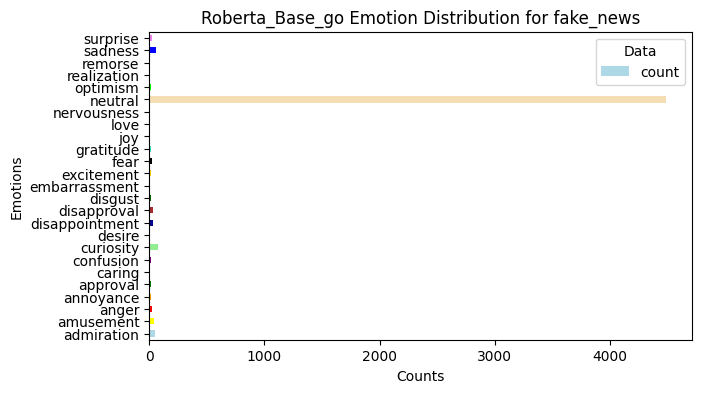

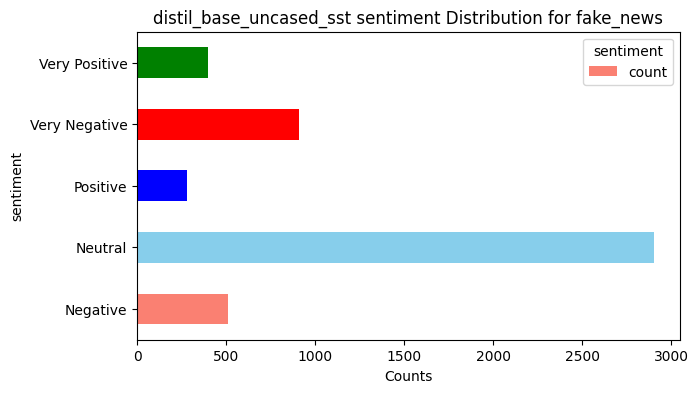

plotting the histograms for emotion and sentiment scores


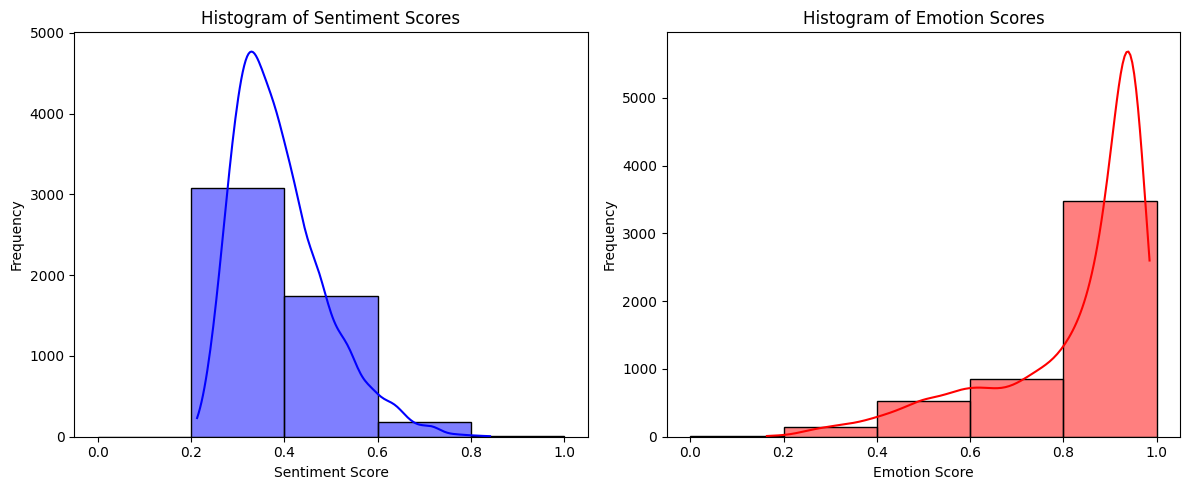


Plotting the mean word length for both datasets



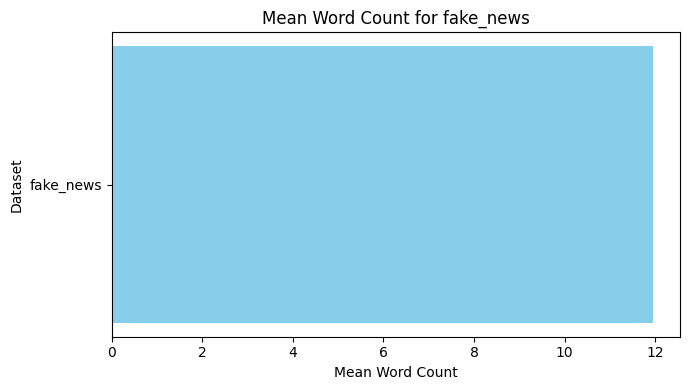



performing PCA to get the overall hate speech score


performing Linear regression assess the relationship between the hate score and the fake news label


 The model summary


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     796.7
Date:                Sun, 23 Feb 2025   Prob (F-statistic):          8.96e-163
Time:                        08:20:27   Log-Likelihood:                -7854.9
No. Observations:                5000   AIC:                         1.571e+04
Df Residuals:                    4998   BIC:                         1.573e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std er



Processing Datasets: 100%|██████████| 1/1 [03:46<00:00, 226.82s/dataset]

Processing Datasets: 100%|██████████| 1/1 [03:46<00:00, 226.82s/dataset]




Saved dataset to : /content/drive/MyDrive/PhD with Rawat/updates obj1_d2/Draft_new_Rawat/draft_2_emotion_scores_headlines_analysis_df.csv




Total experiment runtime: 0hours 3mins 47secs


In [ ]:
# result_output = '/content/drive/MyDrive/PhD with Rawat/updates obj1_d2'
# file_name_text = f'obj1_version3_text_analysis_df.csv'

EMOTIONS = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire",\
            "disappointment", "disapproval", "disgust","embarrassment", "excitement", "fear", "gratitude", "joy",\
            "love", "nervousness", "optimism", "realization", "remorse", "sadness", "surprise", "neutral", 'grief', "pride", "relief"]

class Preprocessor:
    def __init__(self):
        self.patterns= {
            "multi_space": r' +',
            "user_mention": r'@\w+',
            "new_line": r'\n+',
            "hyperlink": r'https?://\S+|www\.\S+',
            "accented": r'\^[a-zA-Z0-9]+',
            "date": r'\b(?:\d{1,2}(?:st|nd|rd|th)?\s(?:Jan|Feb|Mar|...|Dec)[a-z]*\s?\d{4}?)\b',
            "time": r'\b\d{1,2}:\d{2}(?::\d{2})?\s?(?:[aApP][mM])?\b',
            "special_characters": r'[_"\-%;()|+&=*%.,!?:#$@[\]/]',
            "numbers": r'\d+',
            "amper_begin_pattern" : r'^',
            "punctuations" : r'[^\w\s]'
        }
    def expand_abbrev_profanity(self, profanity_df, text):
        for _, row in profanity_df.iterrows():
            abbr = row['abbrv']
            long = row['long']
            text = re.sub(rf'\b{re.escape(abbr)}\b', long, text, flags=re.IGNORECASE)
        return text

    def convert_emojis(self, text):
        return emoji.demojize(text).replace(":", "")

    def number_to_words(self, match):
        return num2words(int(match.group()))

    def process_nums(self, text):
        return re.sub(r'\d+', self.number_to_words, text)

    def remove_stopwords(self, text):
        word_tokens = word_tokenize(text)
        return ' '.join([word for word in word_tokens if word not in stopwords_list])

    # Function to get POS tag for lemmatization
    def get_wordnet_pos(self,word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {
            'J': wordnet.ADJ,
            'N': wordnet.NOUN,
            'V': wordnet.VERB,
            'R': wordnet.ADV }
        return tag_dict.get(tag, wordnet.NOUN)

    # Function to lemmatize text
    def lemmatize_text(self,text):
        tokens = word_tokenize(text.lower())
        lemmatized_tokens = [lemmatizer.lemmatize(word, self.get_wordnet_pos(word)) for word in tokens if word.isalpha()]
        return ' '.join(lemmatized_tokens)

    def text_preprocessing(self, text):
        text = re.sub(self.patterns["date"], '', text)
        text = re.sub(self.patterns["time"], '', text)
        text = self.convert_emojis(text)
        text = re.sub(self.patterns["hyperlink"], '', text)
        text = re.sub(self.patterns["user_mention"], '', text)
        text = re.sub(self.patterns["new_line"], ' ', text)
        text = re.sub(self.patterns["amper_begin_pattern"], '', text)
        text = contractions.fix(text)
        text = self.lemmatize_text(text)
        text = re.sub(self.patterns["multi_space"], ' ', text)
        text = re.sub(self.patterns["special_characters"], ' ', text)
        text = self.process_nums(text)
        text = re.sub(self.patterns["accented"], '', text)
        text = self.remove_stopwords(text)
        text = re.sub(self.patterns["punctuations"], '', text)
        text = text.lower()
        return text.strip()

class Read:
    @staticmethod
    def read_and_filter_dataset (filepath, text_column):
        data = pd.read_csv(filepath, low_memory=False)
        data.dropna(inplace=True)
        return data

class Toxicity:
    def __init__ (self, max_length = 512, batch_size = 10, hate_model_name="GroNLP/hateBERT"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.max_length = max_length
        self.tokenizer = AutoTokenizer.from_pretrained(hate_model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(hate_model_name)
        self.model.eval()

    def get_hate_probability(self, text):
        inputs = self.tokenizer(text,
                              return_tensors="pt",
                              truncation=True,
                              padding=True,
                              max_length=self.max_length)
        with torch.no_grad():
            outputs = self.model(**inputs)

        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        hate_prob = probs[0][1].item()  # Probability of the "hateful" class
        return hate_prob

    def add_hate_scores_to_df(self, df, text_column):
        hate_probs = [self.get_hate_probability(text) for
                      text in df[text_column].fillna("")]
        df["hate_score"] = hate_probs
        return df


    def detoxify_scores(self, df, text_column, delay=1):
        scores_list = []

        for text in df[text_column]:
            try:
                scores = Detoxify('original').predict(text)
            except Exception as e:
                print(f"Error processing text: {text[:30]}... | {e}")
                scores = {'toxicity': None,
                          'severe_toxicity': None,
                          'insult': None,
                          'identity_attack': None,
                          'threat': None}

            scores_list.append(scores)
            time.sleep(delay)  # Avoid overwhelming the system

        scores_df = pd.DataFrame(scores_list)
        df = df.reset_index(drop=True)
        scores_df = scores_df.reset_index(drop=True)
        df = pd.concat([df, scores_df], axis=1)
        return df


    def get_toxicity_scores(self, text):

        data = {
            'comment': {'text': text},
            'requestedAttributes': {
                'TOXICITY': {},
                'SEVERE_TOXICITY': {},
                'INSULT': {},
                'IDENTITY_ATTACK': {},
                'THREAT': {}
            },
            'languages': ['en']
        }

        try:
            response = requests.post(PERSP_URL, json=data)
            response_json = response.json()

            if 'attributeScores' not in response_json:
                print(f"Error processing text: {text} | Response: {response_json}")
                return None  # Return None if API response is invalid

            return {
                'toxicity': response_json['attributeScores']['TOXICITY']['summaryScore']['value'],
                'severe_toxicity': response_json['attributeScores']['SEVERE_TOXICITY']['summaryScore']['value'],
                'insult': response_json['attributeScores']['INSULT']['summaryScore']['value'],
                'identity_attack': response_json['attributeScores']['IDENTITY_ATTACK']['summaryScore']['value'],
                'threat': response_json['attributeScores']['THREAT']['summaryScore']['value']
            }
        except Exception as e:
            print(f"API Request Failed: {e}")
            return None

    def add_toxicity_scores_to_df(self, df, text_column, progress_size, delay=1):
        scores_list = []
        progress_bar = tqdm(total=len(df), desc="Processing texts", unit="text")  # Initialize tqdm manually

        for i, text in enumerate(df[text_column], start=1):
            scores = self.get_toxicity_scores(text)
            if scores is None:
                scores = {'toxicity': None, 'severe_toxicity': None, 'insult': None, 'identity_attack': None, 'threat': None}
            scores_list.append(scores)
            time.sleep(delay)

            # Update progress bar **every 5 texts**
            if i % progress_size == 0 or i == len(df):
                progress_bar.update(progress_size)

        progress_bar.close()

        scores_df = pd.DataFrame(scores_list)
        df = df.reset_index(drop=True)
        scores_df = scores_df.reset_index(drop=True)
        df = pd.concat([df, scores_df], axis=1)  # Merge scores into original dataframe
        return df

class SentimentAnalyzer: #https://huggingface.co/tabularisai/robust-sentiment-analysis
    def __init__(self, model_name='tabularisai/robust-sentiment-analysis'):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                                        ).to(self.device)

    def preprocess(self, text, max_length=512):
        return self.tokenizer(text.lower(),
                              return_tensors="pt",
                              truncation=True,
                              padding=True,
                              max_length=max_length).to(self.device)

    def predict(self, text):
        inputs = self.preprocess(text)
        with torch.no_grad():
            outputs = self.model(**inputs)

        probabilities = F.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=-1).item()
        sentiment_score = probabilities[0, predicted_class].item()

        sentiment_map = {0: "Very Negative",
                         1: "Negative",
                         2: "Neutral",
                         3: "Positive",
                         4: "Very Positive"}
        sentiment_output = []

        sentiment_output.append({
            "sentiment": sentiment_map[predicted_class],
            "sent_score": sentiment_score
            })
        return sentiment_output


    def plot_sentiment_distribution(self, sentiment_column, dataset_name, image_name, model_name = 'distil_base_uncased_sst'):
        sentiment_counts = sentiment_column.value_counts().sort_index()
        colors = {"Very Negative": 'red', 'Negative': 'salmon', 'Neutral': 'skyblue', 'Positive': 'blue', 'Very Positive': 'green'}
        plt.figure(figsize=(7, 4))
        sentiment_counts.plot(kind='barh', color=[colors[sent] for sent in sentiment_counts.index])
        plt.title(f'{model_name} sentiment Distribution for {dataset_name}')
        plt.ylabel('sentiment')
        plt.xlabel('Counts')
        plt.legend(title="sentiment", loc='best')
        plt.savefig(path/image_name)
        plt.show()

class BERTemotion:
      # reference https://huggingface.co/SamLowe/roberta-base-go_emotions
    def __init__(self,  max_length = 512, batch_size = 10, figsize=(20, 7),
                 emotions_color = None,  sent_model_name="SamLowe/roberta-base-go_emotions"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.max_length = max_length
        self.figsize=figsize
        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(sent_model_name)
        self.classifier = pipeline(task="text-classification",
                                   model=sent_model_name,
                                   tokenizer=self.tokenizer,
                                   top_k=True,
                                   truncation=True,
                                   device=0 if torch.cuda.is_available() else -1)
        self.emotion_colors = {
                  "admiration": "lightblue",
                  "amusement": "yellow",
                  "anger": "red",
                  "annoyance": "orange",
                  "approval": "green",
                  "caring": "pink",
                  "confusion": "purple",
                  "curiosity": "lightgreen",
                  "desire": "magenta",
                  "disappointment": "darkblue",
                  "disapproval": "brown",
                  "disgust": "darkgreen",
                  "embarrassment": "lightcoral",
                  "excitement": "gold",
                  "fear": "black",
                  "gratitude": "turquoise",
                  "grief": "grey",
                  "joy": "lightyellow",
                  "love": "red",
                  "nervousness": "lightgrey",
                  "optimism": "lime",
                  "pride": "blue",
                  "realization": "teal",
                  "relief": "lightcyan",
                  "remorse": "darkred",
                  "sadness": "blue",
                  "surprise": "violet",
                  "neutral": "wheat"
                  }


    def predict(self, texts):
          truncated_texts = [
              self.tokenizer.decode(
                  self.tokenizer(text, truncation=True, max_length=self.max_length)['input_ids'],
                  skip_special_tokens=True)
              for text in texts
          ]

          # batch processing for better GPU efficiency
          model_outputs = self.classifier(truncated_texts,
                                          truncation=True,
                                          padding=True,
                                          batch_size=self.batch_size)
          results = []
          for output in model_outputs:
              top_emotion = output[0]
              results.append({
                  "emotion": top_emotion['label'],
                  "emotion_score": top_emotion['score']
              })
          return results

    def plot_emotion_distribution_single(self, emotion_column, dataset_name, image_name, model_name='Roberta_Base_go'):
        emotion_counts = emotion_column.value_counts().sort_index()
        colors = [self.emotion_colors.get(emotion, 'black') for emotion in emotion_counts.index]
        plt.figure(figsize=(7, 4))
        emotion_counts.plot(kind='barh', color=colors)
        plt.title(f'{model_name} Emotion Distribution for {dataset_name}')
        plt.ylabel('Emotions')
        plt.xlabel('Counts')
        plt.legend(title="Data", loc='best')
        plt.savefig(path/image_name)
        plt.show()

    def emotion_counts(self, data):
      return data.value_counts().to_dict()

    def create_sankey_chart(self, data, dataset_name, image_name):
        emotion_count_dict = self.emotion_counts(data)
        all_emotions = list(emotion_count_dict.keys())
        nodes = all_emotions + [dataset_name]
        node_indices = {node: idx for idx, node in enumerate(nodes)}
        links = {
            "source": [],
            "target": [],
            "value": [],
            "color": []
        }
        for emotion, count in emotion_count_dict.items():
            links["source"].append(node_indices[emotion])
            links["target"].append(node_indices[dataset_name])
            links["value"].append(count)
            links['color'].append(self.emotion_colors.get(emotion.lower(), "gray"))
        fig = go.Figure(go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=nodes),
            link=dict(
                source=links["source"],
                target=links["target"],
                value=links["value"],
                color=links["color"])
        ))
        fig.update_layout(title_text=f"Emotion Flow for {dataset_name}", font_size=10)
        fig.write_image(path/image_name)
        fig.show()

    def plot_emo_sent_histograms(self, df, sentiment_col, emotion_col, image_name):
        plt.figure(figsize=(12, 5))
        # Plot Sentiment Score Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[sentiment_col],
                     bins=np.arange(0, 1.2, 0.2),
                     kde=True,
                     color='blue')
        plt.xlabel("Sentiment Score")
        plt.ylabel("Frequency")
        plt.title("Histogram of Sentiment Scores")

        plt.subplot(1, 2, 2)
        sns.histplot(df[emotion_col], bins=np.arange(0, 1.2, 0.2), kde=True, color='red')
        plt.xlabel("Emotion Score")
        plt.ylabel("Frequency")
        plt.title("Histogram of Emotion Scores")
        plt.savefig(path/image_name)
        plt.tight_layout()
        plt.show()

    def simulate_emotion_scores(df, emotion_column, score_column):
      #create separta emotions socres for each emotion(like on hot encoding)
        for emotion in EMOTIONS:
            df[f"{emotion}_score"] = 0
        for idx, row in df.iterrows():
            detected_emotion = row[emotion_column]
            confidence_score = row[score_column]
            if detected_emotion in EMOTIONS:
                df.at[idx, f"{detected_emotion}_score"] = confidence_score

        return df

class DimReducer:
    def dim_reduction(self, df, features_reduced):
      # Standardize
      scaler = StandardScaler()
      X_scaled = scaler.fit_transform(df[features_reduced])
      pca = PCA_dim_red(n_components=1)
      unified_scores = pca.fit_transform(X_scaled)
      df['hate_speech_score'] = unified_scores
      return df

    def linear_reg(self, df):
      X = sm.add_constant(df['label'])  # Intercept term
      y = yeojohnson(df['hate_speech_score'])[0]
      model = sm.OLS(y, X).fit()
      print(model.summary())
      return model.summary()

class Analysis:
    def __init__(self, colors= ['skyblue', 'salmon', 'green', 'red', 'orange', 'blue' ], figsize = (7, 4)):
        self.figsize = figsize
        self.colors = colors

    def exploratory_data_analysis(self, data, text_column):
        data['word_count'] = data[text_column].str.split().str.len() if text_column else 0 #num of words in sentence
        return data

    def plot_mean_word_length_single(self, dataset, dataset_name, image_name):
        mean_word_count = dataset['word_count'].mean()
        plt.figure(figsize=(7, 4))
        plt.barh(dataset_name, mean_word_count, color='skyblue')
        plt.xlabel("Mean Word Count")
        plt.ylabel("Dataset")
        plt.title(f"Mean Word Count for {dataset_name}")
        plt.tight_layout()
        plt.savefig(f"{image_name}.png")
        plt.show()

def main():
   # Initialize the classes
    preprocessor = Preprocessor()
    reader = Read()
    analyser = Analysis()
    emotion = BERTemotion()
    sentiment_analyser = SentimentAnalyzer()
    kaggle.api.authenticate()
    toxic = Toxicity()
    reducer = DimReducer()

    start_time = time.time()  # Start timer

    min_count = 2500
    progress_size = 50

    fake_curated = pd.read_csv('WELFake_Dataset.csv', index_col = 0) #news articles from Kaggle, McIntire, Reuters, BuzzFeed Political
    fake_curated = fake_curated.dropna(subset=['title', 'text'])
    fake_curated.drop_duplicates(keep='first', inplace = True, ignore_index= True)

    fake_news_df = pd.concat([
    fake_curated[fake_curated['label'] == 1].sample(n=min_count, random_state=42),
    fake_curated[fake_curated['label'] == 0].sample(n=min_count, random_state=42)]
                                 ).sample(frac=1, random_state=42).reset_index(drop=True)

    print(fake_curated.isna().sum())

    datasets = {
        # ("hate_speech", "text"): hate_news_df,
        ("fake_news", "title"): fake_news_df
    }

    features_reduced = ['toxicity',	'severe_toxicity', 'insult',	'identity_attack',	'threat',	'hate_score','admiration_score', 'amusement_score',
                        'anger_score', 'annoyance_score', 'approval_score', 'caring_score', 'confusion_score', 'curiosity_score', 'desire_score',
                        'disappointment_score', 'disapproval_score', 'disgust_score', 'embarrassment_score', 'excitement_score', 'fear_score',
                        'gratitude_score', 'joy_score', 'love_score', 'nervousness_score','optimism_score', 'realization_score', 'remorse_score',
                        'sadness_score', 'surprise_score', 'neutral_score', 'grief_score', 'pride_score', 'relief_score']

    for (dataset_name, headlines), dataset in tqdm(datasets.items(),
                                        desc="\n\nProcessing Datasets",
                                        unit="dataset"):
        print('\n\n\nStarting toxicity score with Google Perspective API!\n')
        dataset = toxic.add_toxicity_scores_to_df(dataset, headlines, progress_size= progress_size)
        dataset = toxic.detoxify_scores(dataset, headlines)

        print('\n\nStarting hate scores with hatebert!\n')
        dataset = toxic.add_hate_scores_to_df(dataset, headlines)

        print('\n\nStarting emotion analysis!\n')
        predictions = list(tqdm(emotion.predict(dataset[headlines].tolist()),
                                desc="Emotion Analysis", unit="text"))
        dataset['emotion'] = [result['emotion'] for result in predictions]
        dataset['emotion_score'] = [result['emotion_score'] for result in predictions]

        print('\n\nperfroming one hot encoding on the emotion scores')
        dataset = simulate_emotion_scores(dataset, emotion_column ='emotion', score_column='emotion_score')


        print('\nStarting sentiment analysis!\n')
        dataset[['sentiment', 'sentiment_score']] = dataset[headlines].apply(lambda x: pd.Series(sentiment_analyser.predict(x)[0]))

        print(f'\n\n++++++++++++++++++Building the {dataset_name.upper()} sankey charts++++++++++++++++++')
        emotion.create_sankey_chart(
            dataset['emotion'],dataset_name, f'sankey_charts_for_{dataset_name}_data.png'
            )

        print('\nStartin text preprocessing!\n')
        dataset["cleaned_processed_text"] = list(tqdm(dataset[headlines].apply(
            preprocessor.text_preprocessing),
            desc="Text Preprocessing", unit="text"))

        print('plotting emotion and sentiment analysis')

        emotion.plot_emotion_distribution_single(dataset['emotion'], dataset_name, image_name="emotion_dist.png")

        sentiment_analyser.plot_sentiment_distribution(dataset['sentiment'], dataset_name, image_name = 'sentiment_distr.png')

        print('plotting the histograms for emotion and sentiment scores')
        emotion.plot_emo_sent_histograms(dataset, image_name='emot_sent_distr.png', sentiment_col ='sentiment_score', emotion_col='emotion_score')

        exploratory_results = {dataset_name: analyser.exploratory_data_analysis(dataset, headlines)}

        print("\nPlotting the mean word length for both datasets\n")
        analyser.plot_mean_word_length_single(dataset, dataset_name, "mean_word_length_distribution.png")

        print('\n\nperforming PCA to get the overall hate speech score')
        dataset = reducer.dim_reduction(dataset, features_reduced)

        print('\n\nperforming Linear regression assess the relationship between the hate score and the fake news label')
        print('\n\n The model summary\n\n')
        summary = reducer.linear_reg(dataset)

        #saving everything for future assessment
        file_name_title = f'draft_2_emotion_scores_headlines_analysis_df.csv'
        file_path = os.path.join(path, file_name_title)
        dataset.to_csv(file_path, index=False)

        print(f"\n\n\nSaved dataset to : {file_path}\n")

        # End timer
    end_time = time.time()
    total_time_seconds = end_time - start_time
    hours = int(total_time_seconds // 3600)
    minutes = int((total_time_seconds % 3600) // 60)
    seconds = int(total_time_seconds % 60)
    print(f"\n\n\nTotal experiment runtime: {hours}hours {minutes}mins {seconds}secs")

    return dataset

if __name__ == "__main__":
  fake_news_df = main()

# what is we do not add in all the emotion scores to the PCA but normalise the data with yEO-jOHNSON

In [ ]:
from scipy.stats import boxcox, yeojohnson

new_fake_curated = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/updates obj1_d2/Draft_new_Rawat/TOXICITY_HATEBERT /obj1_version3_headlines_analysis_df.csv')

features_reduced = ['toxicity',	'severe_toxicity', 'insult',	'identity_attack',	'threat',	'hate_score']

class DimReducer:
    def dim_reduction(self, df, features_reduced):
      # Standardize
      scaler = StandardScaler()
      X_scaled = scaler.fit_transform(df[features_reduced])
      pca = PCA_dim_red(n_components=1)
      unified_scores = pca.fit_transform(X_scaled)
      df['hate_speech_score'] = unified_scores
      return df

    def log_transform(self, x):
        """Helper function to perform log10 transformation with offset"""
        return np.log10(x - x.min() + 1)

    def linear_reg(self, df):
      # if (df['hate_speech_score'] <= 0).any():
      #     df['hate_speech_score'] = df['hate_speech_score'] + abs(df['hate_speech_score'].min()) + 1  # Shift values
      # df['hate_speech_score'] = np.log1p(df['hate_speech_score'])  # Log transformation not appropriate
      # y_scaled = scale(df['hate_speech_score']) #following moslehs simulation
      # y = log_transform(y_scaled)

      X = sm.add_constant(df['label'])  # Intercept term
      y = yeojohnson(df['hate_speech_score'])[0]
      model = sm.OLS(y, X).fit()
      print(model.summary())
      return model.summary()


reducer = DimReducer()

print('\n\nperforming PCA to get the overall hate speech score')

new_fake_curated = reducer.dim_reduction(new_fake_curated, features_reduced)

print('\n\nperforming Linear regression assess the relationship between the hate score and the fake news label')
print('\n\n The model summary\n\n')
summary = reducer.linear_reg(new_fake_curated)



performing PCA to get the overall hate speech score


performing Linear regression assess the relationship between the hate score and the fake news label


 The model summary


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     706.0
Date:                Sun, 23 Feb 2025   Prob (F-statistic):          1.28e-145
Time:                        13:40:45   Log-Likelihood:                -7769.8
No. Observations:                5000   AIC:                         1.554e+04
Df Residuals:                    4998   BIC:                         1.556e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std er

# iNTERPRETATION

- Fake news articles contain significantly more hateful language than real news and since p < 0.0001, it means it’s unlikely due to chance.

- from the f-stats, we see that the model is significant i.e the lables have a real effect on the hate speech score

- The model explains 13.7% of the variance (R-squared = 0.137), meaning there are other factors affecting hate speech intensity that are not captured by just looking at the fake vs. real label.

# part 2 - trying with llms

- We will prompt for the toxicity, hate scores, sentiments, emotions and their scores

- Re compute the unified hate hate score via PCA

- then get an ols model summary

- Assess the discrepancies in emotion and sentiment between part 1 and part 2

- Possibly get human evaluations

In [ ]:
class LLM_sentiment:
    def prompt_cohere(self, event, model_name= 'command'):

      prompt = f"Given the following event: '{event}', identify the primary sentiment it evokes. \
      Select only one of the following sentiment labels (in lowercase): 'positive', 'negative', or 'neutral'. \
      Provide only the sentiment label without any additional explanation."

      co_api = cohere.Client('COHERE_PROD')
      response = co_api.chat(
          message=prompt,
          model=model_name,
      )
      return response.text

    def sentiment_gpt(self, event, model_name='gpt-4o-mini'):
      prompt = f"""
      Given the following event: '{event}', determine the primary sentiment it evokes.

      Step 1: Identify the sentiment as one of the following sentiment labels in lowercase: 'very negative', 'negative', 'neutral', 'positive', 'very positive'. \
      Step 2: Assign a confidence score between 0 and 1, formatted to exactly five decimal places, based on how strongly the sentiment is expressed.

      Expected Response format:

      sentiment: 'very negative', 'negative', 'neutral', 'positive', or 'very positive'
      confidence: value between 0 and 1, formatted to exactly five decimal places

      Ensure that the response strictly follows this format, without any additional explanation, commentary or justification.
      """

      client = OpenAI(
          api_key = 'api key'
                    )
      input = [
          {"role": "system", "content": "You are a sentiment analysis expert."},
          {"role": "user", "content": prompt},
      ]
      chat_completion = client.chat.completions.create(
          messages=input,
          model=model_name,
      )
      output = chat_completion.choices[0].message.content
      # Parse the structured response
      lines = output.strip().split("\n")
      sentiment = lines[0].split(": ")[1].strip().lower().replace("'", "").replace('"', "")  # Remove quotes and standardize
      confidence = float(lines[1].split(": ")[1].strip())  # Convert confidence score to float
      return {"sentiment": sentiment, "confidence_score": confidence}


    def emotion_gpt(self, event, model_name= 'gpt-4o-mini'):
      prompt = f"""
      Given the following event: '{event}', determine the primary emotion it evokes.

      Step 1: Select the single most relevant emotion from the following list, in lowercase, without additional explanation: 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'

      step 2: Assign a confidence score between 0 and 1, formatted to exactly five decimal places, indicating the strength and certainty of the classification.

      Your response should be in the following structured format:

      emotion: chosen emotion from Step 1
      confidence: value between 0 and 1, formatted to exactly five decimal places

      Ensure that the response strictly follows this format, without any additional explanation, commentary or justification."""

      client = OpenAI(
          api_key = 'api key'
                    )
      input = [{"role": "system", "content": "You are a emotion analysis expert."},
              {"role": "user","content": prompt,}]
      chat_completion = client.chat.completions.create(
          messages=input,
          model=model_name,
      )
      output = chat_completion.choices[0].message.content

      lines = output.strip().split("\n")
      emotion = lines[0].split(": ")[1].strip().lower().replace("'", "").replace('"', "")
      confidence_str = lines[1].split(": ")[1].strip()
      confidence_str = confidence_str.replace('[', '').replace(']', '')  # Remove square brackets
      confidence = float(confidence_str)
      return {"emotion": emotion, "emotion_score": confidence}

    def hate_gpt(self, event, model_name= 'gpt-4o-mini'):
      prompt = f"""
      Given the following event: '{event}', provide a score between 0 and 1, formatted to exactly five decimal places, to measure its overall hatefulness.

      Your response must strictly follow the required format, providing only the hatefulness score between 0 and 1, formatted to exactly five decimal places, without additional explanations, commentary, or justifications."""

      client = OpenAI(
          api_key = 'api key'
          )
      input = [{"role": "system", "content": "You are a hate speech detection expert."},
              {"role": "user","content": prompt,}]
      chat_completion = client.chat.completions.create(
          messages=input,
          model=model_name,
      )
      output = chat_completion.choices[0].message.content
      return output

    def toxicity_hate_gpt(self, text, model_name='gpt-4o-mini'):
      prompt = f"""
      Given the following text: '{text}', assess its toxicity and hatefulness using these attributes.

      Step 1: Assign a score (between 0 and 1, rounded to 5 decimal places) for each of the following categories:
      - TOXICITY: General toxicity level.
      - SEVERE_TOXICITY: Extreme toxicity, highly offensive content.
      - INSULT: Direct insults or abusive language.
      - THREAT: Expressions of harm or violence.
      - PROFANITY: Use of vulgar,offensive or swear words.
      - IDENTITY_ATTACK: Attacks on identity-based traits (e.g., race, gender, religion).
      - HATE_SCORE: Measures hatefulness.

      Step 2: Format the response strictly as follows:
      toxicity_scores:
        TOXICITY: value between 0 and 1 rounded to 5 decimal places
        SEVERE_TOXICITY: value between 0 and 1 rounded to 5 decimal places
        INSULT: value between 0 and 1 rounded to 5 decimal places
        THREAT: value between 0 and 1 rounded to 5 decimal places
        PROFANITY: value between 0 and 1 rounded to 5 decimal places
        IDENTITY_ATTACK: value between 0 and 1 rounded to 5 decimal places
        HATE_SCORE: value between 0 and 1 rounded to 5 decimal places
      Ensure that the response strictly follows this format, without any additional explanation, commentary or justification.
      """

      client = OpenAI(
          api_key = 'api key'
          )

      input_messages = [
          {"role": "system", "content": "You are a toxicity and hate speech analysis expert."},
          {"role": "user", "content": prompt}
      ]

      chat_completion = client.chat.completions.create(
          messages=input_messages,
          model=model_name,
      )

      output = chat_completion.choices[0].message.content.strip()

      lines = output.strip().split("\n")

      if len(lines) < 7:
        raise ValueError("Unexpected response format from the model")

      try:
          toxicity = float(lines[0].split(": ")[1].strip()).lower().replace("'", "").replace('"', "")
          severe_toxicity = float(lines[1].split(": ")[1].strip())
          insult = float(lines[2].split(": ")[1].strip())
          threat = float(lines[3].split(": ")[1].strip())
          profanity = float(lines[4].split(": ")[1].strip())
          identity_attack = float(lines[5].split(": ")[1].strip())
          hate_score = float(lines[6].split(": ")[1].strip())
      except (IndexError, ValueError) as e:
          raise ValueError("Error parsing the model response") from e

      return {"toxicity": toxicity,
              "severe_toxicity": severe_toxicity,
              "insult": insult,
              "threat": threat,
              "profanity": profanity,
              "identity_attack": identity_attack,
              'hate_score': hate_score}

def main():
  llm_prompt = LLM_sentiment()
  fake_news_df = pd.read_csv('/content/drive/MyDrive/PhD with Rawat/updates obj1_d2/Draft_new_Rawat/TOXICITY_HATEBERT /obj1_version3_headlines_analysis_df.csv')
  fake_news_llm_df = fake_news_df[['title', 'text', 'label']]

  dataset = fake_news_llm_df.sample(5, random_state=42).reset_index(drop=True)

  sent_col = ['sentiment', 'sentiment_score']
  emo_col = ['emotion', 'emotion_score']
  toxic_col = ["toxicity", "severe_toxicity", "insult", "threat", "profanity", "identity_attack", "hate_score"]

  dataset[sent_col] = dataset['title'].apply(lambda x: pd.Series(llm_prompt.sentiment_gpt(x)))
  dataset[emo_col] = dataset['title'].apply(lambda x: pd.Series(llm_prompt.emotion_gpt(x)))
  dataset['hate_score'] = dataset['title'].apply(lambda x: pd.Series(llm_prompt.hate_gpt(x)))

  return dataset
  # #saving everything for future assessment
  # file_name_title = f'llm_emotion_scores_headlines_analysis_df.csv'
  # file_path = os.path.join(path, file_name_title)
  # dataset.to_csv(file_path, index=False)

  # print(f"\n\n\nSaved dataset to : {file_path}\n")
if __name__ == "__main__":
  dataset = main()

# to be continued...